In [44]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
import tensorflow.keras as keras
import umap

In [33]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)

numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df = pd.concat([df, umap_df], axis=1)
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

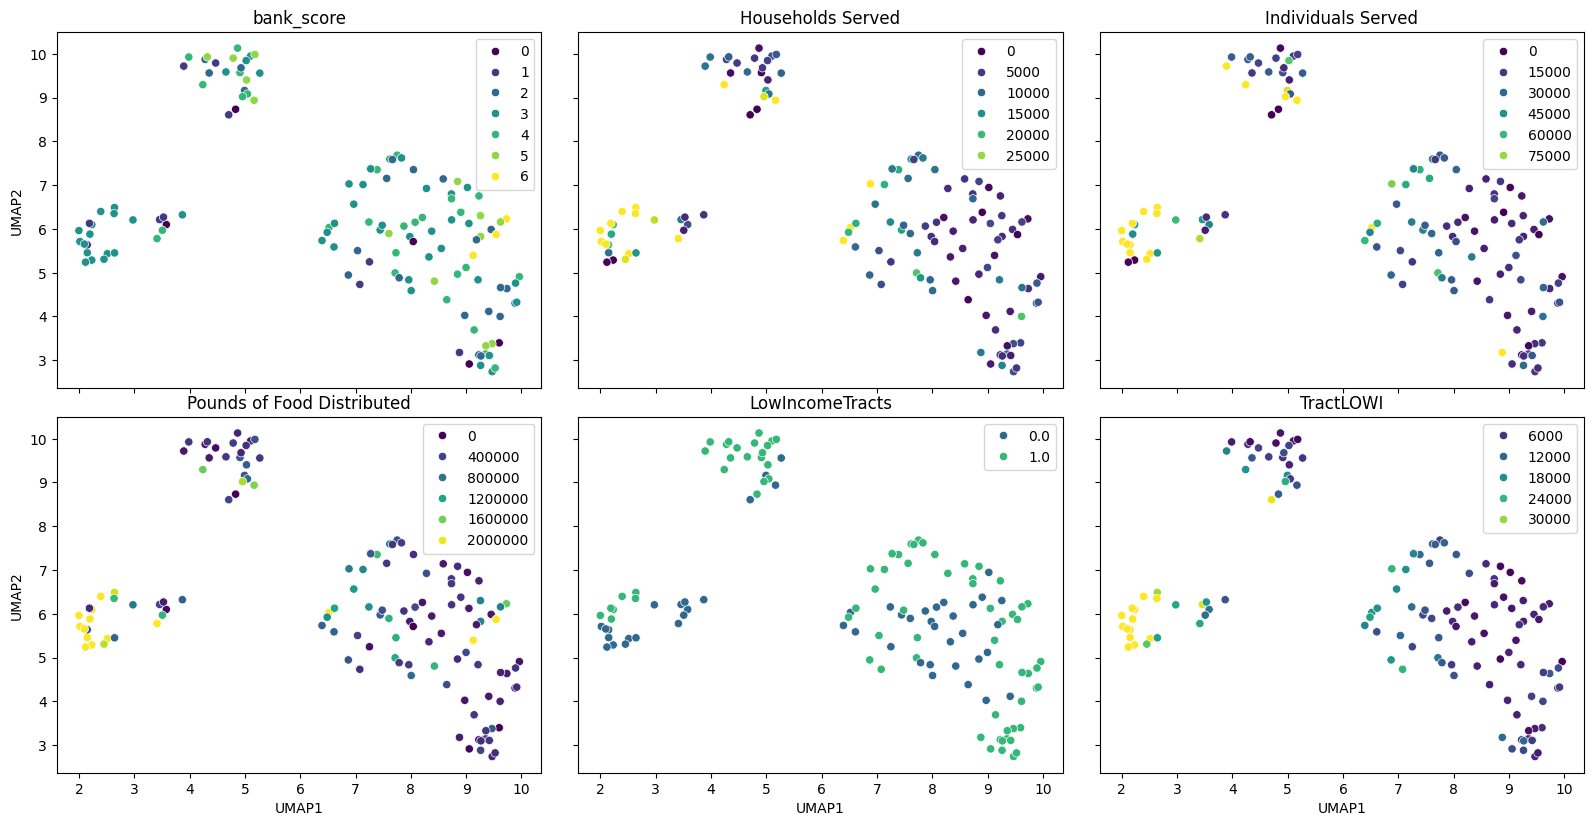

In [91]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

features_plotted = ['bank_score', 'Households Served', 'Individuals Served',
                    'Pounds of Food Distributed', 'LowIncomeTracts', 'TractLOWI']

# fig = make_subplots(rows=2, cols=3, subplot_titles=features_plotted)
# for i, feature in enumerate(features_plotted):
#     fig.add_trace(
#         go.Scatter(x=df['UMAP1'], y=df['UMAP2'], mode='markers',
#                    marker=dict(color=df[feature], colorscale='viridis', opacity=0.5, showscale=True),
#                    showlegend=False),
#         row=i // 3 + 1, col=i % 3 + 1)
        
# fig.show()

fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
plt.tight_layout()
for i, feature in enumerate(features_plotted):
    ax = axs[i // 3][i % 3]
    scatter = sns.scatterplot(
        x='UMAP1', y='UMAP2', data=df, hue=feature,
        ax=ax, palette='viridis', legend='brief'
    )
    scatter.legend_.set_title(None)
    ax.set_title(feature)

plt.savefig('mult_scatter.png')

In [71]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(scaled_data)
df['cluster'] = kmeans.labels_
cluster_sizes = df.groupby('cluster').size()
df['weights'] = df['cluster'].apply(lambda x: 1 / cluster_sizes[x])

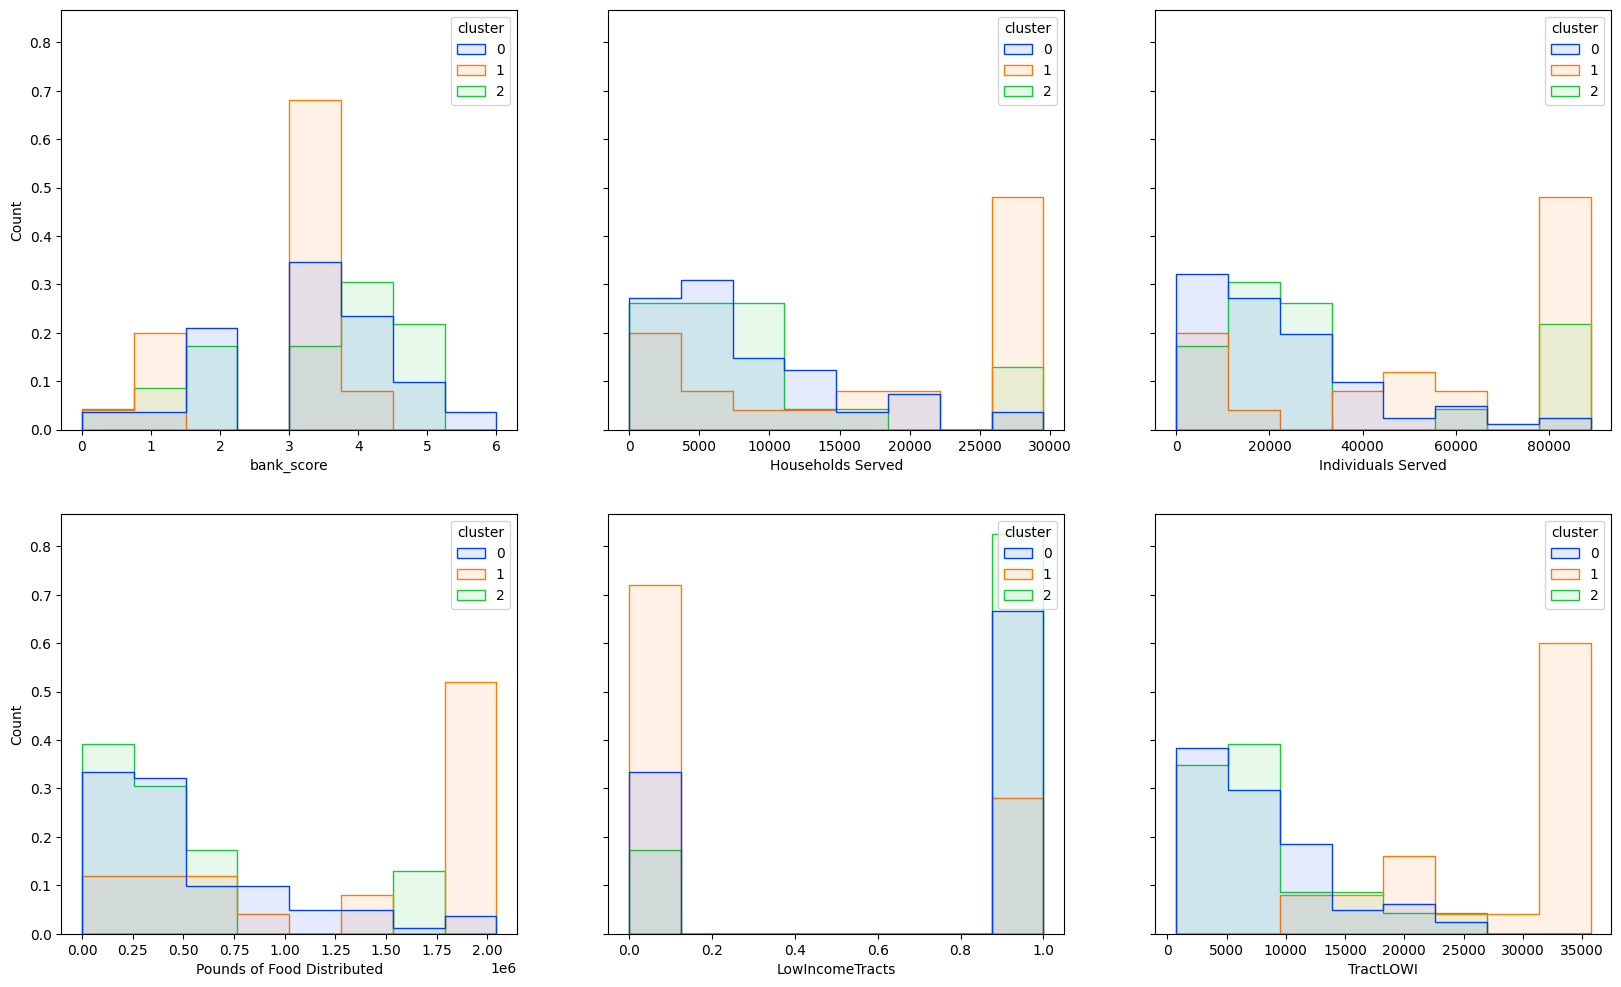

In [92]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12), sharey=True)

for i, feature in enumerate(features_plotted):
    ax = axs[i // 3][i % 3]
    hist = sns.histplot(
        data=df, x=feature, bins=8, hue='cluster', ax=ax,
        element='step', palette='bright', weights='weights', alpha=0.1
    )
    # scatter.legend_.set_title(None)

plt.savefig('mult_hist.png')

In [75]:
# Use k-means to cluster data and plot distribution of bank scores by cluster
fig = px.histogram(
    df, x="bank_score", color="cluster",
    opacity=0.6, barmode='overlay', title="Distribution of Bank Scores by Cluster"
)
fig.show()
fig.write_image("umap_bank_score.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
# from umap.parametric_umap import ParametricUMAP
# reducer = ParametricUMAP(n_training_epochs=100)
# embedding = reducer.fit_transform(scaled_data)

# umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
# score = df['Pounds of Food Distributed'] / df['TractLOWI']
# min_score = np.min([val for val in score if val > 0.0])
# imputed_score = np.array([min_score if val == 0.0 else val for val in score])
# umap_df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

# plt.figure()
# sns.scatterplot(
#     x="UMAP1", y="UMAP2",
#     hue="bank_score",
#     palette=sns.color_palette("viridis", as_cmap=True),
#     data=umap_df,
#     legend="auto"
# )

# plt.title("Parametric UMAP of Non-Encoded Data with Bank Score")